# Ocean and Land Temperature Anomalies
**The Boyz are back**


---
**Team Members**


*   Saffian Asghar
*   Alexis Culpin
*   Romaric Sallustre
*   Emilio Espinosa S.



---


**Datasets**

* NOAA_URL = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json"
* BERKLEY_URL = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt"
* HAD_CRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv"



---

**Features**
* The dataset is collected from NOAA, Berkeley Earth and CRUT5
* The chosen time period is from 1850 - Present.
* Some of the interesting columns are confidence limits in the dataset from CRUT 5.
* The dataset from Berkley Earth has a range of missing values from 2012 to 2023 in specific columns.
* The formats of the data includes csv, txt and json. Further data transformations will be updated sometime.


* France data description field : *
* features * : 

Basic climatological data - daily
Description
Presentation
Climatological data from all French and overseas stations since their opening, for all available parameters. These data have been climatologically checked.

Technical information
Daily data are available for download, by department and by period batch, in compressed csv format.
All parameters are provided for all weather stations.
Times are expressed in UTC for mainland France and in FU for overseas territories
Files are updated annually for historical data prior to 1950, monthly for data from 1950 to year -2, and daily for the last two years.

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `NUM_POSTE`  | Météo-France station number on 8 digits                                                                          |
| `NOM_USUEL`  | Common name of the station                                                                                       |
| `LAT`        | Latitude, negative in the south (in degrees and millionths of a degree)                                          |
| `LON`        | Longitude, negative west of GREENWICH (in degrees and millionths of a degree)                                    |
| `ALTI`       | Altitude of the shelter base or rain gauge if no shelter (in meters)                                             |
| `AAAAMMJJ`   | Measurement date (year month day)                                                                                |
| `RR`         | Amount of precipitation fallen in 24 hours (from 06h UTC on day J to 06h UTC on day J+1). Value for day J is recorded at J+1 (in mm and tenths) |
| `TN`         | Minimum temperature under shelter (in °C and tenths)                                                             |
| `HTN`        | Time of TN (hhmm)                                                                                                |
| `TX`         | Maximum temperature under shelter (in °C and tenths)                                                             |
| `HTX`        | Time of TX (hhmm)                                                                                                |
| `TM`         | Daily average of hourly temperatures under shelter (in °C and tenths)                                            |
| `TNTXM`      | Daily average (TN+TX)/2 (in °C and tenths)                                                                       |
| `TAMPLI`     | Daily thermal amplitude: difference between daily TX and TN (TX-TN) (in °C and tenths)                           |
| `TNSOL`      | Daily minimum temperature 10 cm above ground (in °C and tenths)                                                  |
| `TN50`       | Daily minimum temperature 50 cm above ground (in °C and tenths)                                                  |
| `DG`         | Duration of frost under shelter (T ≤ 0°C) (in minutes)                                                           |
| `FFM`        | Daily average wind force averaged over 10 minutes, at 10 m (in m/s and tenths)                                   |
| `FF2M`       | Daily average wind force averaged over 10 minutes, at 2 m (in m/s and tenths)                                    |
| `FXY`        | Daily maximum of maximum hourly wind force averaged over 10 minutes, at 10 m (in m/s and tenths)                 |
| `DXY`        | Direction of FXY (in compass points of 360)                                                                      |
| `HXY`        | Time of FXY (hhmm)                                                                                               |
| `FXI`        | Daily maximum of maximum hourly instantaneous wind force, at 10 m (in m/s and tenths)                            |
| `DXI`        | Direction of FXI (in compass points of 360)                                                                      |
| `HXI`        | Time of FXI (hhmm)                                                                                               |
| `FXI2`       | Daily maximum of maximum hourly instantaneous wind force, at 2 m (in m/s and tenths)                             |
| `DXI2`       | Direction of FXI2 (in compass points of 360)                                                                     |
| `HXI2`       | Time of FXI2 (hhmm)                                                                                              |
| `FXI3S`      | Daily maximum of maximum hourly wind force averaged over 3 seconds, at 10 m (in m/s and tenths)                  |
| `DXI3S`      | Direction of FXI3S (in compass points of 360)                                                                    |
| `HXI3S`      | Time of FXI3S (hhmm)                                                                                             |

Quality codes associated with each data point (e.g., T;QT):
- `9`: Filtered data (the data has passed first-level filters/controls)
- `0`: Protected data (the data has been definitively validated by the climatologist)
- `1`: Validated data (the data has been validated by automatic control or by the climatologist)
- `2`: Doubtful data under review (the data has been questioned by automatic control)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Save URL into
NOAA_URL = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json"
BERKLEY_URL = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt"
HAD_CRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv"

# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1871-1949
ardennes_RR_T_wind_1871_1949_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_1871-1949_RR-T-Vent.csv.gz"
# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1950 - 2022
ardennes_RR_T_wind_1950_2022_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_autres-parametres.csv.gz"
# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period # Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1950 - 2023 - 2024
ardennes_RR_T_wind_2023_2024_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_RR-T-Vent.csv.gz"

# field description : https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_descriptif_champs_RR-T-Vent.csv

In [ ]:
# Read Json file
df_noaa = pd.read_json(NOAA_URL)

# Dataframe drop unnecessary columns ...
df_noaa = (
    df_noaa
    .drop('description', axis=1)
    .loc[pd.to_numeric(df_noaa.index, errors='coerce').notna()]
)
# Set index as int
df_noaa.index = df_noaa.index.astype(int)
# Rename columns with specific format
df_noaa = df_noaa.rename(columns=lambda x: f"NOAAGlobalTemp ({df_noaa.index.min()} - {df_noaa.index.max()})")
df_noaa.head()

,NOAAGlobalTemp (1850 - 2023)
1850,-0.06
1851,-0.08
1852,-0.01
1853,-0.12
1854,0.02


In [ ]:
# read second dataset
had_crut5_df = pd.read_csv(HAD_CRUT5_URL, parse_dates=['Time'])
# Group by year and calculate average per year.
had_crut5_df = (
    had_crut5_df
    .groupby(had_crut5_df['Time'].dt.year)['Anomaly (deg C)'].mean().reset_index()
    .set_index('Time')
)
# Set index as int
had_crut5_df.index = had_crut5_df.index.astype(int)
had_crut5_df.head()

,Anomaly (deg C)
Time,
1850,-0.417711
1851,-0.233350
1852,-0.229399
1853,-0.270354
1854,-0.291521


In [ ]:
# Read third dataset
berkley_df = pd.read_csv(BERKLEY_URL, comment="%", delim_whitespace=True, names= ["year", "month", "anomaly", "yearAvgAnomaly", "5yearAvgAnomaly", "10yearAvgAnomaly", "20yearAvgAnomaly"])
# Group by year and calculate average per year.
berkley_df = (
    berkley_df
    .groupby(berkley_df['year'])['anomaly'].mean().reset_index()
    .set_index('year')
)
# berkley_df = berkley_df.assign(realTemp = berkley_df['anomaly'] + 14.40)
berkley_df.index = berkley_df.index.astype(int)
berkley_df

,anomaly
year,
1850,-1.141667
1851,-0.971583
1852,-1.007917
1853,-0.382333
1854,-0.170500
...,...
2019,1.199167
2020,1.391000
2021,1.160500


In [ ]:
# Join the two datasets based on the common 'index' (year)
merged_df = (
    df_noaa
    .join(had_crut5_df.rename(columns={'Anomaly (deg C)': 'HadCRUT5_Anomaly'}), how='left')
    .join(berkley_df.rename(columns={'anomaly':'Berkley_anomaly'}), how='left')
)

# Rename the new column as per your specified format
merged_df = (
    merged_df
    .rename(columns={'HadCRUT5_Anomaly': f"HAD_CRUT5 ({had_crut5_df.index.min()} - {had_crut5_df.index.max()})"})
    .rename(columns={'Berkley_anomaly': f"BerkleyEarth ({berkley_df.index.min()} - {berkley_df.index.max()})"})
)

In [ ]:
merged_df

,NOAAGlobalTemp (1850 - 2023),HAD_CRUT5 (1850 - 2023),BerkleyEarth (1850 - 2023)
1850,-0.06,-0.417711,-1.141667
1851,-0.08,-0.233350,-0.971583
1852,-0.01,-0.229399,-1.007917
1853,-0.12,-0.270354,-0.382333
1854,0.02,-0.291521,-0.170500
...,...,...,...
2019,1.12,0.891073,1.199167
2020,0.83,0.922921,1.391000
2021,0.90,0.761906,1.160500
2022,0.83,0.801305,1.205750


<AxesSubplot: title={'center': 'Global Temperature change'}>

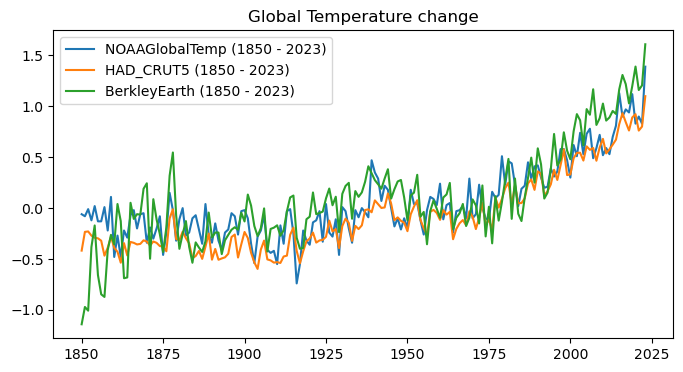

In [ ]:
merged_df.plot(kind='line', figsize=(8, 4), title='Global Temperature change')